## Machine Learning and Statistics Project 2020
***


The aim of this project is to create a web service that uses machine learning to make predictions based on the data set 'powerproduction'. The goal is to produce a model that accurately predicts wind turbine power output from wind speed values, as in the data set. Then, to develop a web service that will respond with predicted power values based on speed values sent as HTTP requests.

<br>



<br>

## Introduction

***

This notebook builds the predictive model as described in the project brief. It details the process involved in producing the model through explanation of the model choice, following evaluation of its accuracy and comparison with other models.

There are a number of steps involved in creating an accurate predictive model. This project follows these steps, providing explanations for the choice of model used through analysis of the *powerproduction* data set. With this in mind, it is divided into the following sections:

* Preliminary Analysis
* Function Approximation (Regression vs Classification)
* Regression with `scikit-learn`
* Regression with `keras`
* Model evaluation

<br>



## 1. Preliminary Analysis

***

First, I import the modules needed and choose a style for visualisation throughout the project:

* `numpy` is a python library which allows us to work with arrays, more suited to data analysis than traditional python `lists` [1] 
* `pandas` is suited to working with data sets and provides the DataFrame structure to make this more effective and efficient [2]. 
* `matplotlib.pyplot` is used for visualisation. It is a graph plotting library on which many visualisation packages are built in python. The `pyplot` submodule contains most of matplotlib's utilities [3]
* With the `scikit-learn` library, we have access to numerous machine learning algorithms [4]. In this project it is used to generate predictive models and also to evaluate those models. 
* `tensorflow` is a machine learning platform with a focus on working with and training neural networks [5]. `keras` is an API built on tensorflow, providing an interface for working with neural networks [6].

In [1]:
# Working with arrays
import numpy as np

# Working with dataframes
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt

# Linear regression algorithm
from sklearn.linear_model import LinearRegression

# Working with more complex variable relationships
from sklearn.preprocessing import PolynomialFeatures

# Metrics for evaluation
from sklearn.metrics import mean_squared_error, r2_score

# Splitting data into train and test sets
from sklearn.model_selection import train_test_split

# Working with neural networks
import tensorflow.keras as kr

In [2]:
# Plot style
plt.style.use('ggplot')

# Plot size
plt.rcParams['figure.figsize'] = [11, 6]

Next, I read in the dataset using `pandas.read_csv` which stores the data in a pandas dataframe. I assign this to `pp` and output the first 10 rows. With `pandas.describe` we get a statistical summary of the data set:

In [3]:
# Read in data set
pp = pd.read_csv('powerproduction.csv')

# Output first 10 rows
pp.head(10)

,speed,power
0,0.000,0.000
1,0.125,0.000
2,0.150,0.000
3,0.225,0.000
4,0.275,0.000
5,0.325,4.331
6,0.400,5.186
7,0.450,3.826
8,0.501,1.048
9,0.526,5.553


In [4]:
# Output summary statistics of data set
pp.describe()

,speed,power
count,500.000000,500.000000
mean,12.590398,48.014584
std,7.224991,41.614572
min,0.000000,0.000000
25%,6.324750,5.288000
50%,12.550500,41.645500
75%,18.775250,93.537000
max,25.000000,113.556000


The data set contains two continuous variables. To get an overview of the relationship between them, we can plot them using a scatterplot. Visualising this relationship is a useful first step in understanding what predictive model might be suitable. It can also offer other insights, such as the presence of outliers: 

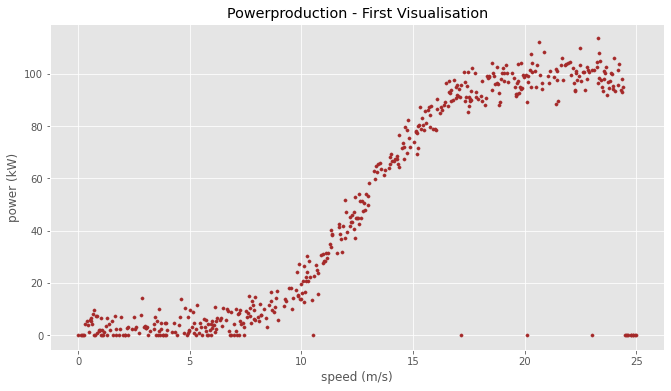

In [5]:
# Plot data on a scatter plot
plt.title('Powerproduction - First Visualisation')
plt.xlabel('speed (m/s)')
plt.ylabel('power (kW)')
plt.scatter(pp['speed'], pp['power'], color='brown', marker='o', s=10)

#### Wind Turbine Power Curve
This plot produces a visualisation of the typical wind turbine power curve. The *cut-in* wind speed is at ~7m/s, below which the turbine is producing hardly any power. Between wind speeds of ~7 and ~17m/s the power ramps up to what is known as the *rated power capacity*. From speeds of ~17m/s the power generated remains constant, right up to ~25m/s, or the *cut-out* wind speed. While there is much potential power in the wind speed above the cut-out speed, the cost of making the turbine capable of producing power under these conditions outweights the benefits of more power being generated [7]. <br>

**note:** *I have assigned the above units of measurement to each variable, kilowatts (kW) for power and meters-per-second (m/s) for wind speed. This makes the explanations throughout the project clearer. These units were deduced following a quick Google search*

#### Outliers
What is also notable from the plot is the presence of seeming outliers in the data. There are a number of observations where no power (0kW) is being generated despite sufficiently high wind speeds. This will be examined in greater detail below.

#### What Predictive Model?
Through visualisation we can get a preliminary indication of what model might best be suited when predicting power output from wind speed. Initial inclinations would suggest that this is a *regression* problem. Given that there are only two variables in the data set, simple linear regression may be an appropriate model although fitting a straight line to the data may not yield the most accurate predictions. It might be more suitable to fit a curve. The variables are clearly *positively* correlated between the *cut-in* speed and the *rated power capacity*. 

##### end section 1

<br>



## 2. Function Approximation: Classification vs Regression

***

The term *Function approximation* describes the problem of approximating a mapping function from input variables to output variables. Generally speaking, function approximation problems can be divided into *classification* and *regression* tasks [8]. Deciding between which of these is most appropriate for the current project is the next step.

#### Classification vs Regression
"Classification predictive modeling is the task of approximating a mapping function (f) from input variables (X) to *discrete* output variables (y)" [9], while the output variables for regression models are *continuous* numeric variables. The aim of the current project is to predict power output from wind speed. As noted above, this is a continuous numeric variable which tells us that regression is an appropriate model/function for this task.

#### Regression
Regression is a statistical method which describes the relationship between a dependent variable and one or more independent variables [10]. Additionally, it is associated with fitting a line (or curve) to the data by plotting the line over the data points to get the best fit [11]. Taking a look data as plotted on a scatter plot, it is clear that we could fit a line (or curve) in order to accurately predict the dependent variable.



##### end section 2

<br>



## 3. Regression with `scikit-learn`

***

`scikit-learn` is a machine learning library for the python programming language. It provides a range of machine learning algorithms and is used widely for the purposes of predictive modelling [12]. In the current project, `scikit-learn`'s `LinearRegression` class will be used to apply a model to the *powerproduction* data set. Additionally, the package provides a number of tools which will be used to prepare the data and evaluate the models created below.

### 3.1 Data preparation

***

Before building the first model, it is necessary to prepare the data to maximise the ultimate accuracy of the predictions. Firstly, I use a function to detect any outliers in order to improve the performance of the models. Second, I split the data set into subsets using the *train-test split* procedure.


#### 3.1.1 Outliers

When training a predictive model, it is important to remove any outliers so that the data we train the model on fully represents the observed data. The removal of outliers must be handled sensitively and cautiously so as not to misrepresent the data, and because every data set is different, there is often a lack of clearly defined rules around how to deal with them [13].

Prior to removing any identified outliers, let us first see how a simple linear regression (SLR) model performs with the orignial data set. The data is split into training and testing data. This procedure is explored and explained in greater detail below:

In [6]:
# Using original (pp) data set to train model 
speed_df_pp = pp.drop('power',axis='columns')
power_df_pp = pp.drop('speed',axis='columns')

# Train test split
A_Train_pp, A_Test_pp, B_Train_pp, B_Test_pp = train_test_split(speed_df_pp, power_df_pp, test_size = 0.5, random_state=1)

# Generate instance of the LinearRegression class to create model
reg_pp = LinearRegression()

# Call the fit method to train model
reg_pp.fit(A_Train_pp, B_Train_pp)

# Calculate R-squared value for evaluation
score_pp = reg_pp.score(A_Test_pp, B_Test_pp)

# Print score
print(score_pp)

0.7196585822445968


Training the model using the full data set yields a score of **~0.72**. This represents the R-Squared value also known as the *coefficient of determination* [23]. The R-squared value is a 'goodness-of-fit' measure which can give us an indication as to the accuracy of our regression model. The best possible score is 1, while a score of 0 generally represents a worse-fitting line. The R-squared value "indicates the percentage of the variance in the dependent variable that the independent variables explain collectively." [24] It is worth noting that a high R-squared does not necessarily always indicate the best fit [25].

The trained model is then used to make predictions based on the test data. We can use this prediction to plot a line to visualise how well it fits.

<br>

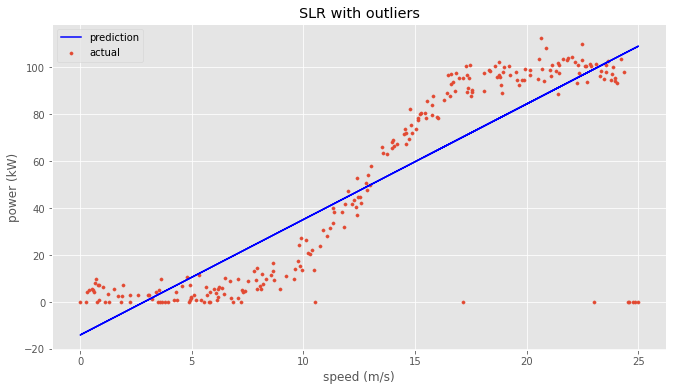

In [7]:
# Use model to make predictions
pp_predict = reg_pp.predict(A_Test_pp)

# Plot fitted line against data for visualisation
plt.scatter(A_Test_pp, B_Test_pp, label='actual', s=10)
plt.plot(A_Test_pp, pp_predict, label='prediction', color='b')

plt.title('SLR with outliers')
plt.xlabel('speed (m/s)')
plt.ylabel('power (kW)')
plt.legend()

Here we can visualise the output predicted by the model from the test data, plotted as a straight line against the scatter plot of both variables. It quite clearly does not accurately fit the data. 

#### 3.1.2 Outlier detection and removal

As mentioned above, visualisation can give us a strong indication that some of the observations may need to be removed. However, statistical methods can also be used to detect extreme or unlikely values in a data set. 

##### Mahalonibis Distance

In researching outlier detection, much of the online resources appear to deal with *univariate* outliers [14], [15]. Additionally, detection tools available as part of the `scikit-learn` library e.g. `LocalOutlierFactor`, (which uses the nearest neighbours algorithm to detect outliers in a sample) were not suited to the current project. For *multivariate* outliers, a common statistical method of dection is the *Mahalonibis Distance* measure, which is "... widely used distance metric for the detection of multivariate outliers..." [16]. Indeed it has been applied to wind turbine curve modeling by a number of studies (e.g. Pei and Li, 2019) [17]. 

The code for the function below was found on an informative blog post [18] and applies Mahalonibis Distance to the data set to detect outliers. It returns a list of index values for the rows containing outliers as detected by the method. I locate these rows using the `pandas.loc` method and remove them from the data set:

In [8]:
import scipy as sp
from scipy.stats import chi2
from sklearn.covariance import MinCovDet

# Set variable df to equal pp data set
df = pp

#Robust Mahalonibis Distance
def robust_mahalanobis_method(df):
    #Minimum covariance determinant
    rng = np.random.RandomState(0)
    real_cov = np.cov(df.values.T)
    X = rng.multivariate_normal(mean=np.mean(df, axis=0), cov=real_cov, size=506)
    cov = MinCovDet(random_state=0).fit(X)
    mcd = cov.covariance_ #robust covariance metric
    robust_mean = cov.location_  #robust mean
    inv_covmat = sp.linalg.inv(mcd) #inverse covariance metric
    
    #Robust M-Distance
    x_minus_mu = df - robust_mean
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    md = np.sqrt(mahal.diagonal())
    
    #Flag as outlier
    outlier = []
    C = np.sqrt(chi2.ppf((1-0.001), df=df.shape[1]))#degrees of freedom = number of variables
    for index, value in enumerate(md):
        if value > C:
            outlier.append(index)
        else:
            continue
    return outlier, md

outliers_mahal_rob, md_rb = robust_mahalanobis_method(df=df)

In [9]:
# Find rows containing outlier indices
pp_outliers = pp.loc[ outliers_mahal_rob , : ]

# Output dataframe of outliers
pp_outliers

,speed,power
340,17.167,0.0
404,20.095,0.0
456,22.998,0.0
490,24.499,0.0
491,24.525,0.0
492,24.575,0.0
493,24.650,0.0
494,24.750,0.0
495,24.775,0.0
496,24.850,0.0


Above is the data frame containing the outlier observations. All the outliers detected have a power value of 0kW. This is what was observed on the scatterplot. Building on the preliminary analysis above, we can see from the data set that the final ten observations have power values of 0kW. Wind speeds of >25.499 do not produce any power, which implies perhaps that the turbine is incapable of generating power above this value. It is reasonable to assume that this is the cut-out speed, where "... the turbine shuts down to avoid damage" [27] and is a common characteristic of wind turbines [28]. Let's take a look at the bottom 20 rows of the original data set to see if this sudden drop-off in power production can be seen from the observations:

In [25]:
# Output bottom 20 rows
pp.tail(20)

,speed,power
480,23.974,94.270
481,24.024,105.992
482,24.049,93.524
483,24.174,95.869
484,24.199,101.419
485,24.249,103.700
486,24.299,93.694
487,24.349,93.078
488,24.374,98.223
489,24.399,95.117


It appears evident that wind speeds above ~24.499 do not produce any power. This should be reflected in our final model. For now, they will be removed from the data set so that the model can be more accurately trained to predict power values for wind speeds below the cut-out. This characteristic will be handled once the model has been trained.

Below, I remove them from the data set, creating an updated data set `pp_updated` in the process:

In [26]:
# Remove outliers from data set
pp_updated = pp.drop(outliers_mahal_rob)

In [27]:
# Output statistical summary of updated data frame
pp_updated.describe()

,speed,power
count,487.000000,487.000000
mean,12.294641,49.296287
std,7.077215,41.409933
min,0.000000,0.000000
25%,6.143500,5.769000
50%,12.337000,44.745000
75%,18.380500,93.733500
max,24.399000,113.556000


Text(0, 0.5, 'power (kW)')

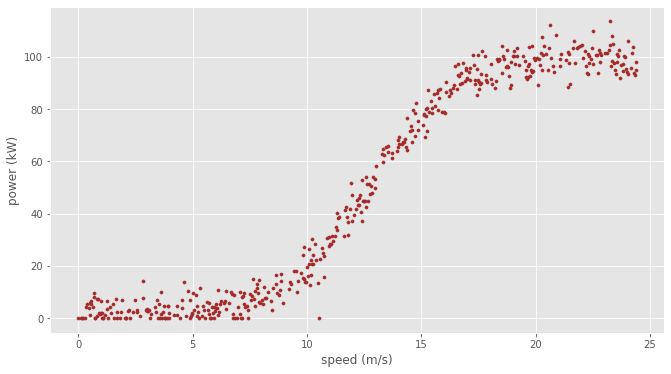

In [28]:
plt.scatter(pp_updated['speed'], pp_updated['power'], color='brown', marker='o', s=10)
plt.xlabel('speed (m/s)')
plt.ylabel('power (kW)')

The Mahalonibis Distance function detected all but one outlier. I will remove this too for improved performance. Firstly, we view the last 5 observations with power = 0kW:


In [29]:
pp_zero = pp_updated.loc[pp_updated['power'] == 0]
pp_zero.tail()

,speed,power
135,6.857,0.0
136,6.957,0.0
140,7.107,0.0
149,7.432,0.0
208,10.511,0.0


We can see that the outlier is at index 208. This can be removed with the following code:

In [30]:
pp_clean = pp_updated.drop([208])

Now we can train the model with the updated data set:

In [33]:
# Train test split
x_train, x_test, y_train, y_test = train_test_split(pp_clean.speed, pp_clean.power, test_size = 0.5, random_state=1)

# Convert to numpy arrays and reshape
reg_speed_train = x_train.to_numpy().reshape(-1, 1)
reg_power_train = y_train.to_numpy().reshape(-1, 1)
reg_speed_test  = x_test.to_numpy().reshape(-1, 1)
reg_power_test = y_test.to_numpy().reshape(-1, 1)


# Create model
reg_pp_clean = LinearRegression()

# Fit model
reg_pp_clean.fit(reg_speed_train, reg_power_train)

# Calculate R-squared value
score_pp_clean = reg_pp_clean.score(reg_speed_test, reg_power_test)

# Print score
print(score_pp_clean)

0.9008406364589567


Once the outliers are removed, the model performs better. It yields a score of **~0.90**. 

<br>

We can plot both models side by side for visual comparison:

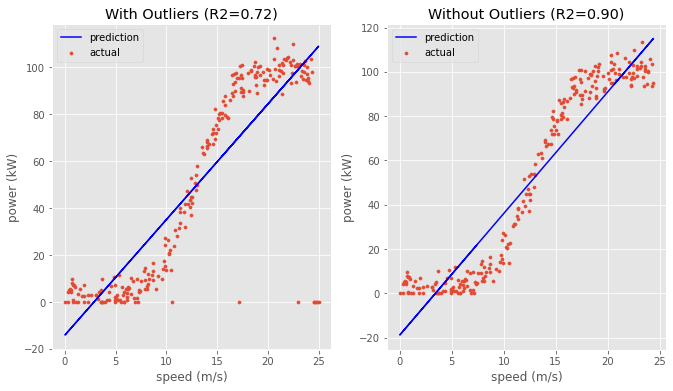

In [34]:
# First subplot
plt.subplot(1, 2, 1)
plt.scatter(A_Test_pp, B_Test_pp, label='actual', s=10)
plt.plot(A_Test_pp, pp_predict, label='prediction', color='b')

plt.title('With Outliers (R2=0.72)')
plt.xlabel('speed (m/s)')
plt.ylabel('power (kW)')
plt.legend()

# Second subplot
plt.subplot(1, 2, 2)

# Call predict method on test data and plot resulting line
pp_updated_predict = reg_pp_clean.predict(reg_speed_test)

plt.scatter(reg_speed_test, reg_power_test, label='actual', s=10)
plt.plot(reg_speed_test, pp_updated_predict, label='prediction', color='b')

plt.title('Without Outliers (R2=0.90)')
plt.xlabel('speed (m/s)')
plt.ylabel('power (kW)')
plt.legend()

When viewed side by side, we see that once the outliers are removed the line is a slightly better fit, although it is clear that a straight line does not manage to capture the data accurately in either model.

<br>

#### 3.1.3 Train-test split

This section provides a brief explanation of the *train-test split* procedure as performed in the previous section.

In machine learning, *evaluation* and *validation* are key aspects in measuring how well a model is performing [19]. To ensure that the potential for bias is minimized when evaluating model performance, it is common practice to apply the *train-test split* procedure. This involves training a model by splitting the data into subsets. The *train* subset is used to train the model while the *test* subset is held back in order to test the model's accuracy. Given that we already know the output values for the test subset, we can make informed comparisons between the predicted observed values. (It is worth pointing out that it may not always be appropriate as a technique to increase accuracy of prediction e.g. if the data set is too small [20].) 


<br>

First, the `pp_clean` data set is split by column into two separate subsets, one containing each variable. :

In [35]:
# Create a new dataset containing only values from the speed column
speed_df = pp_clean.drop('power',axis='columns')

#  Print first 10 rows
speed_df.head(10)

,speed
0,0.000
1,0.125
2,0.150
3,0.225
4,0.275
5,0.325
6,0.400
7,0.450
8,0.501
9,0.526


In [36]:
# Create a new dataset containing only values from the power column
power_df = pp_clean.drop('speed',axis='columns')

# Print first 10 rows
power_df.head(10)

,power
0,0.000
1,0.000
2,0.000
3,0.000
4,0.000
5,4.331
6,5.186
7,3.826
8,1.048
9,5.553


<br>

Next, I pass the speed_df and power_df dataframe subsets to `scikit-learn`'s `train_test_split` method and set the parameter *test_size* to 0.5. The test size indicates the size of the train and test sets. Common split percentages include

* Train: 80%, Test: 20%
* Train: 67%, Test: 33%
* Train: 50%, Test: 50% [21]

The values for the train and test subsets are randomly selected, so I set *random_state* to 1. This reproduces the same division of the data each time the program is run. Setting the seed also allows for more representative model comparison as well as parameter comparison when assessing the performance of different models and functions.

**Note: The code below is an exact copy of the procedure as performed above. This is just for demonstration purposes**

In [19]:
# Call train_test_split method on dataframes
x_train, x_test, y_train, y_test = train_test_split(speed_df, power_df, test_size = 0.5, random_state=1)


<br>

### 3.2 Simple linear regression

***

In demonstrating the importance of outlier removal above, I used simple linear regression models. This section provides a brief explanation of simple linear regression before exploring polynomial regression to create a predictive model.

Simple linear regression is "... the simplest case of linear regression with a single independent variable" [22]. Its equation is often expressed as <br> $$ y = \Theta_0 + \Theta_1x $$ <br> It can be applied when the data set contains only two variables - a dependent and independent variable. This is a condition which is filled by the 'powerproduction' data set. 

Once the outliers were removed, the model as trained on the training data produced a score of ~0.90. For certain predictive models, an R-squared value of ~0.90 might be considered satisfactory. However for the current project, it makes sense to attempt to fit a curve to the data to maximise accuracy of predicted output. The following section applies polynomial regression to the data.


<br>

### 3.3 Polynomial regression

***

Visualising the plots above, we can see that a straight line does not follow the curve of the data. This is an example of *under-fitting* [26]. In order to overcome this problem, the complexity of the model needs to be increased. With polynomial regression, we can generate a curve that better captures the data. It involves generating a higher order equation by adding powers to convert features into their higher order terms [27]. The equation for polynomial regression is commonly expressed as: $$ y = \Theta_0 + \Theta_1x + \Theta_2x^2 + \Theta_3x^3 + ... + \Theta_nx^n $$ <br>

`scikit-learn` provides the `PolynomialFeatures` class which enables us to transform features to their higher order terms by setting the degree parameter to the desired power. Then, this model can be trained using the `LinearRegression` class just as above. The code for this is based on an informative *towardsdatascience.com* blog post [28].

First, the training data is converted to numpy arrays. This makes it easier to sort and plot below. Then, an instance of the `PolynomialFeatures` class is created, generating polynomial degrees to the 9th degree. This is the degree value that yields the highest R-Squared score. The `fit_transform` method applies polynomial transformation of degree 9. The transformed feature (wind speed) is then fit to the model and predictions are made based on the test data. 

In [37]:
# Convert train and test subsets to numpy arrays
poly_speed_train = x_train.to_numpy().reshape(-1, 1)
poly_power_train = y_train.to_numpy().reshape(-1, 1)
poly_speed_test  = x_test.to_numpy().reshape(-1, 1)
poly_power_test = y_test.to_numpy().reshape(-1, 1)

# Create PolynomialFeatures class instance with degree=9
poly_features = PolynomialFeatures(degree=9)

# Apply polynomial transformation of degree 9
train_speed = poly_features.fit_transform(poly_speed_train)

# Create instance of LinearRegression class
poly_model = LinearRegression()

# Train the model with training data
poly_model.fit(train_speed, poly_power_train)

# Use the model to predict power output of test data
y_test_predict = poly_model.predict(poly_features.fit_transform(poly_speed_test))

<br>

Using `sciki-learn`'s evaluation metrics, we can calculate the R-squared value as well as the *mean-squared-error* (mse), which is the most commonly used regression loss function [29]:

In [38]:
# Calculate mean squared error 
mse = mean_squared_error(poly_power_test, y_test_predict)

# Calculate coeeficient of determination
r2 = r2_score(poly_power_test, y_test_predict)

# Output reults to the screen
mse, r2

(18.29934798625694, 0.9895079443988561)

With an R-Squared value of **~0.99** we can see that polynomial regression performs significantly better than the simple linear regression models above. The mse is **~18.29**. This will be compared with additional models below.

<br>

When plotted on a graph, it is clear that the curve captures the data much more closely than simple linear regression:

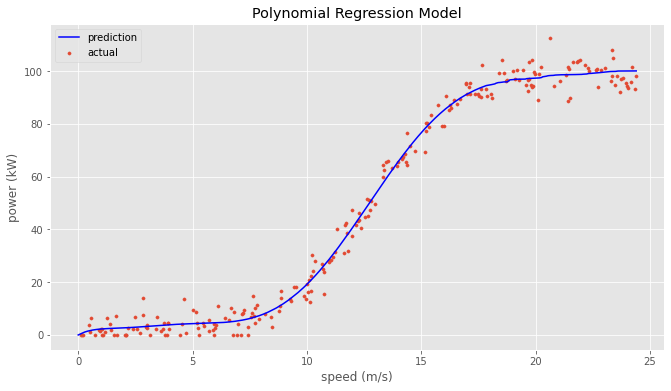

In [39]:
# Plot on scatterplot
plt.scatter(poly_speed_train, poly_power_train, label='actual', s=10)

sorted_poly_speed_test = np.sort(poly_speed_test, 0)
sorted_y_test_predict = np.sort(y_test_predict, 0)


# # Plot line based on model predictions
# plt.plot(sorted_poly_x, sorted_y_test_predict, label='prediction', color='b')
plt.plot(sorted_poly_speed_test, sorted_y_test_predict, label='prediction', color='b')

# Labels
plt.title('Polynomial Regression Model')
plt.xlabel('speed (m/s)')
plt.ylabel('power (kW)')
plt.legend()

In [23]:
llop

NameError: name 'llop' is not defined

## 4. Neural network - Regression with `keras`

***

Neural networks is one of the most commonly used algorithms in machine learning and it covers a broad range of concepts and techniques [30]. Below, I build a neural network which implements regression to predict wind turbine power output from wind speed input. Depending on the nature of the problem to be solved, neural networks can range from simple, with fewer hidden layers (shallower) and fewer neurons in each layer (narrower), to more complex structures (deeper and wider) [31]. 


#### 4.1 Setting parameters
When applying a neural network model to a problem, there are a number of such parameters which can be tuned/set which can minimize the loss function. For the purposes of the current project, I do not make many major tuning adjustments. However below, I give a brief overview of the parameters involved, taking in some key concepts of neural networks in the process:

* **Number of hidden layers**: Adding/removing hidden layers can impact the performance of a neural network
* **Number of neurons**: Increasing/decreasing the number of neurons in a given layer can also minimize the loss function
* **Number of epochs**: When training a model with input data, the algorithm iterates through epochs (cycles). Depending on the data set, a model may need to run through few or many epochs to minimize the loss function sufficiently [32].
* **Batch size**: This refers to the number of training samples the applied to the algorithm before the model's internal parameters are updated [33]
* **Weight parameter**: The neurons in each layer are connected to each previous and subsequent layer, with each connection assigned a weight. For the neural networks created using Keras, this parameter can be set manually or it can be handled by the internal working of the algorithm via the `kernal_initializer` parameter. In the first step of a neural network, the input value is multiplied by its corresponding weight and this is repeated for each input value and added together (dot product between inputs and weights) [34]
* **Bias**: The bias is added to the dot product between inputs and weights. It "... is necessary to make a robust neural network" [35]. Like the weight parameter, the bias can be assigned manually or handled via the `bias_initializer` parameter in each layer. It can ensure, for example, that the dot product will never return a value of zero, which would happen if the input values were zero in a given data set. Adding the bias term is a convention when building neural networks and is often set to 1 as default e.g. in the case described. This calculation can be represented mathematically as: 
<br>

$$f \left( b + \sum_{i=1}^{n}x_iw_i \right)$$ 

<br>

* **Activation function**: The value from this calculation is then passed through an activation function. The activation function essentially predicts the output from for the input features [36]. We can set `activation` parameter to any one of a range of functions as provided by the `keras` library (although the function itself clearly cannot be altered). The default is a linear function which will be used for the output layer for the models below. The sigmoid and relu activation functions will be used in the hidden layers and compared in order to minimise the loss function. 
* **Loss function**: The loss function calculates the error between the predicted and observed output. Its value gives us an indication as to how well our model is performing. When training any predictive model, minimisation of the loss function can be seen as the goal to aim for. For the models below, I will apply MSE (*mean squared error*). This is a commonly used loss function for regression problems and can be expressed mathematically as: 

<br>

$$MSE = \frac{1}{n}\sum_{i=1}^{n}(predicted - observed)^2$$

   where $n$ = numer of observations [37]
* **Optimization algorithm**: The aim of the optimization algorithm is to minimize the loss function. `Keras` provides a range of optimizers. Below, I use the the *Adam* function in all models.

<br>



In [ ]:
# Create neural network with one neuron
def create_model():
    model = kr.models.Sequential()
    model.add(kr.Input(shape=(1,)))
    model.add(kr.layers.Dense(100, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
    model.add(kr.layers.Dense(100, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
    model.add(kr.layers.Dense(1, activation='linear', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
    model.compile(kr.optimizers.Adam(lr=0.001), loss='mean_squared_error')
    
    return model

In [ ]:
model = create_model()

In [ ]:
model.predict([14])

In [ ]:


# msk = np.random.rand(len(pp_clean2)) < 0.5
# train = pp_clean2[msk]

# test = pp_clean2[~msk]

In [ ]:
# model.fit(train['speed'], train['power'], epochs=500, batch_size=10)

In [ ]:
# shapes = model.predict(test['speed'])

In [ ]:
# shapes.shape

In [ ]:
# plt.scatter(test['speed'], test['power'], label='actual', s=10)
# plt.plot(test['speed'], model.predict(test['speed']), label='prediction')
# plt.legend()

In [ ]:
model.fit(x_train, y_train, epochs=500, batch_size=10)

In [ ]:
nn_predict = model.predict(x_test)

nn_predict.shape

In [ ]:
arr_sort = np.sort(nn_predict, axis=0)

In [ ]:
nn_predict = np.sort(nn_predict, axis=0)
A_Test_sort = np.sort(x_test, axis=0)

plt.scatter(x_train, y_train, label='actual', s=10)

# sort_axis_nn = operator.itemgetter(0)
# sorted_zip_nn = sorted(zip(A_Test, nn_predict), key=sort_axis)
# sorted_poly_x_nn, sorted_y_test_predict_nn = zip(*sorted_zip)

plt.plot(A_Test_sort, nn_predict, label='prediction', color='b')
plt.legend()

In [ ]:
model.summary()

In [ ]:
# model.save('my_model.h5')

In [ ]:
model.predict([14])

In [ ]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

dataset = pp_updated.values
# split into input (X) and output (Y) variables
X = dataset[:,0:1]
Y = dataset[:,1]

def some_model():
    model = kr.models.Sequential()
    model.add(kr.Input(shape=(1,)))
    model.add(kr.layers.Dense(10, activation='sigmoid', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
    model.add(kr.layers.Dense(1, activation='linear', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
    model.compile(kr.optimizers.Adam(lr=0.01), loss='mean_squared_error')
    
    return model




# evaluate model with standardized dataset
estimators = []
estimators.append(('standardize', StandardScaler()))
# estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=50, batch_size=5, verbose=0)))
estimators.append(('mlp', KerasRegressor(build_fn=some_model, epochs=300, batch_size=10)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10)
results = cross_val_score(pipeline, X, Y, cv=kfold)

In [ ]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

dataset = pp_updated.values
# split into input (X) and output (Y) variables
X = dataset[:,0:1]
Y = dataset[:,1]
# define base model
def baseline_model():
    model = kr.models.Sequential()
    model.add(kr.Input(shape=(1,)))
    model.add(kr.layers.Dense(100, activation='sigmoid', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
#     model.add(kr.layers.Dense(100, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
    model.add(kr.layers.Dense(1, activation='linear', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
    model.compile(kr.optimizers.Adam(lr=0.01), loss='mean_squared_error')
    
    return model




# evaluate model with standardized dataset
estimators = []
estimators.append(('standardize', StandardScaler()))
# estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=50, batch_size=5, verbose=0)))
estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=300, batch_size=10)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10)
results = cross_val_score(pipeline, X, Y, cv=kfold)


In [ ]:

def another_model():
    model = kr.models.Sequential()
    model.add(kr.Input(shape=(1,)))
    model.add(kr.layers.Dense(100, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
#     model.add(kr.layers.Dense(100, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
    model.add(kr.layers.Dense(1, activation='linear', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
    model.compile(kr.optimizers.Adam(lr=0.01), loss='mean_squared_error')
    
    return model







# evaluate model with standardized dataset
estimators = []
estimators.append(('standardize', StandardScaler()))
# estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=50, batch_size=5, verbose=0)))
estimators.append(('mlp', KerasRegressor(build_fn=another_model, epochs=100, batch_size=10)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10)
results = cross_val_score(pipeline, X, Y, cv=kfold)

In [ ]:
# Create neural network with one neuron
def create_model2():
    model = kr.models.Sequential()
    model.add(kr.Input(shape=(1,)))
    model.add(kr.layers.Dense(100, activation='sigmoid', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
    model.add(kr.layers.Dense(100, activation='sigmoid', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
    model.add(kr.layers.Dense(1, activation='linear', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
    model.compile(kr.optimizers.Adam(lr=0.001), loss='mean_squared_error')
    
    return model

estimators = []
estimators.append(('standardize', StandardScaler()))
# estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=50, batch_size=5, verbose=0)))
estimators.append(('mlp', KerasRegressor(build_fn=create_model, epochs=100, batch_size=10)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10)
results = cross_val_score(pipeline, X, Y, cv=kfold)

In [ ]:
# 1 layer, sigmoid, 100 epochs, lr=0.01 = 18.19
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std())) 

In [ ]:
# 1 layer, sigmoid, 300 epochs, lr=0.001 = 17.80, 17.35
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))

In [ ]:
# 1 layer, sigmoid, 300 epochs, lr=0.01 - 16.98
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))

In [ ]:
# 1 layer, relu, 100 epochs, lr=0.01- 17.79, 21.94, 48.13
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))

In [ ]:
# relu, 10 units, 100 epochs, lr=0.01 = 84.82
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))

In [ ]:
# create_model (adding extra layer doesn't make a difference) - 17.43
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))

In [ ]:
create_model2 = create_model()

In [ ]:
create_model2.fit(x_train, y_train, epochs=100, batch_size=10)

In [ ]:
model.predict([99])

In [ ]:
baseline_model = baseline_model()
baseline_model.fit(x_train, y_train, epochs=100, batch_size=10)

In [ ]:
float(baseline_model.predict([14]))


In [ ]:
def model_test(wind_speed):
    
    """
    Returns a list of predicted wind turbine power values from an array of wind speed inputs
    """
    
    # Initialise empty list
    power_prediction = []
    
    # Loop through wind speed array
    for i in range(len(wind_speed)):
        if wind_speed[i] >= 24.499 or wind_speed[i] < 0.3: # return 0.000 for values above 24.499 and below 0.3
            power_prediction.append(0.0)
        else:
            #baseline_model.predict(wind_speed[i])
            power_prediction.append(float(baseline_model.predict(wind_speed)[i])) # final predictive model
    
    return power_prediction

In [ ]:
x_test1 = x_test.reset_index()

In [ ]:
model_test(ho)

In [ ]:
ho = [0.1, 14, 0.2, 25]
ho = np.array(ho)
ho[1]

In [ ]:
baseline_model.predict(ho)[0]

In [ ]:
model_test(pp.speed)

In [ ]:
len(pp.speed)

In [ ]:
np.random.seed(0)
x = 2 - 3 * np.random.normal(0, 1, 20)
y = x - 2 * (x ** 2) + 0.5 * (x ** 3) + np.random.normal(-3, 3, 20)

# transforming the data to include another axis
x = x[:, np.newaxis]
y = y[:, np.newaxis]

polynomial_features= PolynomialFeatures(degree=2)
x_poly = polynomial_features.fit_transform(x)

model = LinearRegression()
model.fit(x_poly, y)
y_poly_pred = model.predict(x_poly)

rmse = np.sqrt(mean_squared_error(y,y_poly_pred))
r2 = r2_score(y,y_poly_pred)
print(rmse)
print(r2)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
model2 = GradientBoostingRegressor(random_state=0).fit(A_Train, B_Train.values.ravel())

print(model2.score(A_Train, B_Train))

print(model2.score(A_Test, B_Test))
pred = model2.predict(A_Test)
pred = np.sort(pred, 0)

In [ ]:

from sklearn.ensemble import RandomForestRegressor
model3 = RandomForestRegressor(random_state=0).fit(A_Train, B_Train.values.ravel())
model3.score(A_Train, B_Train)

model3.score(A_Test, B_Test)
pred2 = model3.predict(A_Test)
pred2 = np.sort(pred2, 0)

In [ ]:
# # Use model to make predictions
# pp_predict = reg_pp.predict(A_Test_pp)

# Plot fitted line against data for visualisation
plt.scatter(A_Test, B_Test, label='actual', s=10)
plt.plot(A_Test, pred2, label='prediction', color='b')

plt.xlabel('speed (m/s)')
plt.ylabel('power (kW)')
plt.legend()

### References

[1] w3schools.com; Numpy Introduction; https://www.w3schools.com/python/numpy_intro.asp <br>
[2] w3schools.com; Pandas Tutorial https://www.w3schools.com/python/pandas_tutorial.asp <br>
[3] w3schools.com; Matplotlib Pyplot; https://www.w3schools.com/python/matplotlib_pyplot.asp <br>
[4] wikipedia.org; scikit_learn https://en.wikipedia.org/wiki/Scikit-learn <br>
[5] tensorflow.org; https://www.tensorflow.org/ <br>
[6] keras.io; https://keras.io/ <br>
[7] youtube.com; Wind Turbine Power Curve description; https://www.youtube.com/watch?v=8tNOL4ZL9Do <br>
[8] Brownlee, J.; Difference Between Classification and Regression in Machine Learning https://machinelearningmastery.com/classification-versus-regression-in-machine-learning/ <br>
[9] *Ibid* <br>
[10] Wikipedia.org; Regression analysis; https://en.wikipedia.org/wiki/Regression_analysis <br>
[11] yale.edu; Linear Regression; http://www.stat.yale.edu/Courses/1997-98/101/linreg.htm <br>
[12] wikipdeia.org; scikit-learn; https://en.wikipedia.org/wiki/Scikit-learn <br>
[13] realpython.com; Split Your Dataset With scikit-learn's train_test_split(); https://realpython.com/train-test-split-python-data/ <br>
[14] machinelearningmastery.com; Train-Test Split for Evaluating Machine Learning Algorithms; https://machinelearningmastery.com/train-test-split-for-evaluating-machine-learning-algorithms/ <br>
[15] *Ibid* <br>
[16] Detecting And Treating Outliers In Python — Part 2; https://towardsdatascience.com/detecting-and-treating-outliers-in-python-part-2-3a3319ec2c33 <br>
[17] Pei, S. and Li, P., 2019; Wind Turbine Power Curve Modeling with a Hybrid Machine Learning Technique; https://www.researchgate.net/publication/337325612_Wind_Turbine_Power_Curve_Modeling_with_a_Hybrid_Machine_Learning_Technique <br>
[18] Detecting And Treating Outliers In Python — Part 2; https://towardsdatascience.com/detecting-and-treating-outliers-in-python-part-2-3a3319ec2c33 <br>
[27] National Wind Watch; FAQ — Technology; https://www.wind-watch.org/faq-technology.php
[28] *Ibid.* <br>
[19] Brownlee, J; How to Remove Outliers for Machine Learning; https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/ <br>
[20] *Ibid* <br>
[21] Frost, J; 5 Ways to Find Outliers in Your Data; https://statisticsbyjim.com/basics/outliers/ <br>
[22] realpython.com; Linear Regression in Python; https://realpython.com/linear-regression-in-python/ <br>
[23] realpython.com; Linear Regression in Python; https://realpython.com/linear-regression-in-python/ <br>
[24] Frost, J; How To Interpret R-squared in Regression Analysis; https://statisticsbyjim.com/regression/interpret-r-squared-regression/ <br>
[25] *Ibid* <br>
[26] Agarwal, A.; Polynomial Regression; https://towardsdatascience.com/polynomial-regression-bbe8b9d97491 <br>
[27] *Ibid* <br>
[28] *Ibid* <br>
[29] Grove, P; 5 Regression Loss Functions All Machine Learners Should Know; https://heartbeat.fritz.ai/5-regression-loss-functions-all-machine-learners-should-know-4fb140e9d4b0 <br>
[30] Starmer, J; Neural Networks Part 1: Inside the Black Box; https://www.youtube.com/watch?v=CqOfi41LfDw <br>
[31] Brownlee, J; Regression Tutorial with the Keras Deep Learning Library in Python; https://machinelearningmastery.com/regression-tutorial-keras-deep-learning-library-python/ <br>
[32] baeldung.com; The Difference Between Epoch and Iteration in Neural Networks; https://www.baeldung.com/cs/neural-networks-epoch-vs-iteration <br>
[33] Brownlee, J; Difference Between a Batch and an Epoch in a Neural Network; https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/ <br>
[34] Usman, M; Creating a Neural Network from Scratch in Python; https://stackabuse.com/creating-a-neural-network-from-scratch-in-python/ <br>
[35] *Ibid.* <br>
[36] *Ibid.* <br>
[37] *Ibid.* <br>